<b>LING 530A 002<br>
Assignment 1: Word Embeddings<br>
2019-09-26<br>
Kaili Vesik</b>


Import all necessary packages to be used below.

In [1]:
from time import time
import string
import re
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import collections
import matplotlib.pyplot as plt
import random
from math import log
import pandas
import numpy as np
from gensim.models import Word2Vec


print("imports complete")

imports complete


C:\Users\Kaili-Pants\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


<b>Step 1</b>: Extract all the text filds from the YELP dataset, and write these fields into a single (text) file.<br>
I discovered partway through my work on this assignment that not only does the preprocessed .json file cut off in the middle of its last entry, but also it does not in fact even include everything from the original dataset. So I ended up deciding to use the raw data instead (1).<br><br>
For this step, I researched file input/ouput in Python (2), extracting substrings using regular expressions (3), dealing with undefined characters (4), interpreting exacped characters (5), and how to time code execution (6).

In [2]:


t=time()
# open the raw data file, interpreting escape sequences as well as ignoring undefined characters, 
# and rewrite processed data to a new file
with open('yelp_dataset_challenge_academic_dataset','r', encoding='unicode_escape', errors='ignore') as yelp:
    with open('reviews.txt','w+', errors='ignore') as reviews:

        line = yelp.readline()
        try:
            while line:
                # look for a "text" field
                m = re.search('"text": "(.+?)", "[A-Za-z]+.+":', line) # 
                if m:
                    # extract the review text and write it to the new file
                    thereview = m.group(1)
                    reviews.write(thereview)
                    reviews.write('\n')
                line = yelp.readline()
            
        except Exception as e:
            print("failed on text: ", line)
            print(e)
            
print('Time to read and rewrite reviews: {} mins'.format(round((time() - t) / 60, 2)))


Time to read and rewrite reviews: 0.66 mins


<b>Step 2</b>: Extract a word frequency dictionary of the data, and print the top most frequent 20 words.<br>
I have decided to do this after Step 3, so that the word frequency is calculated based on the input that has had stopwords removed and has been tokenized.

<b>Step 3</b>: Use NLTK or SpaCy to remove stop words, tokenize, and pos tag the data.<br>
In order to make sure sentences and words both got tokenized in a reasonable way, and in an attempt to make sure words (particularly proper nouns) got tagged as acurately as possible, I did a great deal of experimentation with the order of stripping punctuation (7), removing stopwords (8), changing to lowercase, tokenizing, and tagging (9). I wanted to leave punctuation in while sentence tokenizing, but remove it for the purposes of word tokenizing and frequency-counting). Although we will see later that proper nouns still don't get tagged terribly accurately, I decided that we were better off underidentifying (not many proper nouns get tagged) rather than overidentifying (uppercase letters were deemed significant even when they were not). I also discovered that although tokenized words are necessary for frequency counts and POS tagging, sentences should also be tokenized for better success with the Word2Vec embeddings later on. As it turns out, this step has an incredibly high time cost. I'm frustrated that I didn't come up with a more efficient way of doing this.

In [3]:
t=time()
# read file containining review text and tokenize sentences using NLTK
with open('reviews.txt','r') as reviews:
    thefile = reviews.read()
    sents = sent_tokenize(thefile)

# prepare to remove stop words from sentences as well as build a list of individual tokenized words
stopwds = set(stopwords.words('english'))
wdsnostops = []
sentsnostops = []

for sent in sents:
    # remove punctuation from each sentence in order to tokenize words
    wdtkns = word_tokenize(sent.translate(str.maketrans('', '', string.punctuation)))
    
    # build list of tokenized words as well as list of sentences (list of lists of words), 
    # removing stopwords and using lowercase
    this_sent = []
    for w in wdtkns:
        wd = w.lower()
        if wd not in stopwds:
            this_sent.append(wd)
    sentsnostops.append(this_sent)
    wdsnostops.extend(this_sent)

# use NLTK to POS-tag revised list of words
tagged = pos_tag(wdsnostops)

print('Time to clean, tokenize, and tag: {} mins'.format(round((time() - t) / 60, 2)))    




Time to clean, tokenize, and tag: 56.55 mins


... back to <b>Step 2</b>: Extract a word frequency dictionary of the data, and print the top most frequent 20 words.<br>
I am doing this step after it was originally requested so that the word frequency dictionary corresponds to the tokenized forms of the (non-stopword) words.<br><br>
For this step, I researched frequency distribution (9).

In [4]:
# create a frequency distribution of the tokenized words, 
# then print the top 20 with their frequencies
wdfqdist = nltk.FreqDist(wdsnostops)
print("Most frequent 20 words: ", wdfqdist.most_common(20))


Most frequent 20 words:  [('great', 590757), ('food', 565015), ('place', 556364), ('good', 538057), ('service', 411982), ('time', 321025), ('get', 308136), ('like', 293971), ('back', 286607), ('go', 273644), ('one', 268617), ('would', 246813), ('best', 227222), ('really', 224615), ('love', 219351), ('nice', 191652), ('always', 186755), ('got', 175414), ('staff', 175156), ('friendly', 172620)]


<b>Step 4a</b>: Plot a histogram of the the frequencies of a random sample of tokens in the data (pick 100 tokens).<br>
In order to create an atual histogram (and not a bar graph), I needed numerical data for both variables. So I have used the (log) frequencies of 100 random words to fill the "bins" on the x-axis, and counted on the y-axis how many of those 100 words have each frequency.<br><br>
For this step, I researched how to plot a histogram (10), as well as how to change plot figure size (11) and font size (12).

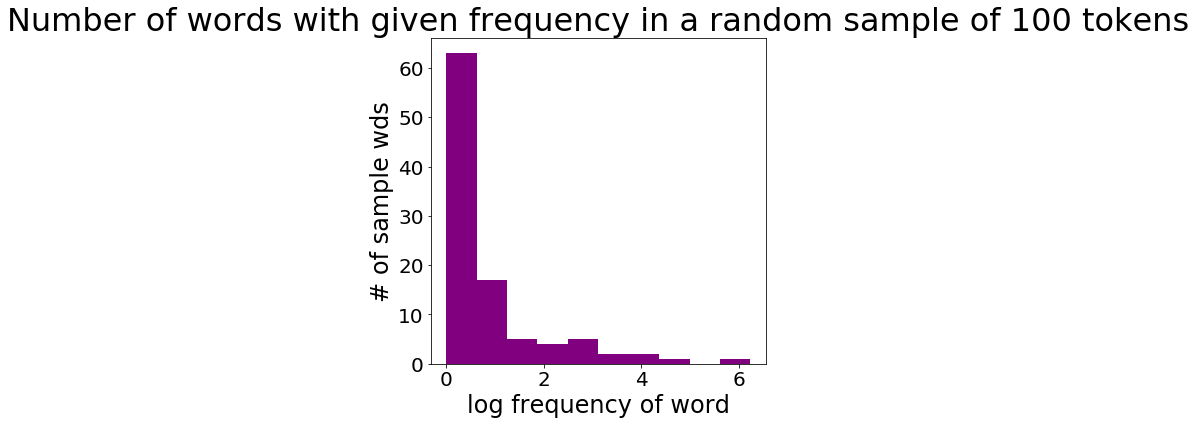

In [5]:
# choose a random sample of 100 words from the word frequency dictionary, and log their frequencies
rand100 = random.sample([(word,i) for word, i in wdfqdist.most_common()],100)
rand100logfreq = [(wd, log(float(freq))) for wd, freq in rand100]

# populate a data frame with the frequency data, set the aesthetics of a histogram plot, and display the histogram
thedata = pandas.DataFrame(rand100logfreq, columns = ['word' , 'logfreq'])
plt.rc('axes', titlesize=32)
plt.rc('axes', labelsize=24)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20) 
fig = plt.figure(figsize=(6,6))
plt.hist(thedata['logfreq'], facecolor='purple')
plt.title('Number of words with given frequency in a random sample of 100 tokens')
plt.xlabel('log frequency of word')
plt.ylabel('# of sample wds')

plt.show();
    

<b>Step 4b</b>: Plot a histogram of the frequencies of all the pos tags assigned by the tagger.<br>
In this case I decided to go with a bar graph, since it is particularly interesting to actually see the frequency of each tag.<br><br>
For this step, I researched how to plot bar graphs (13).

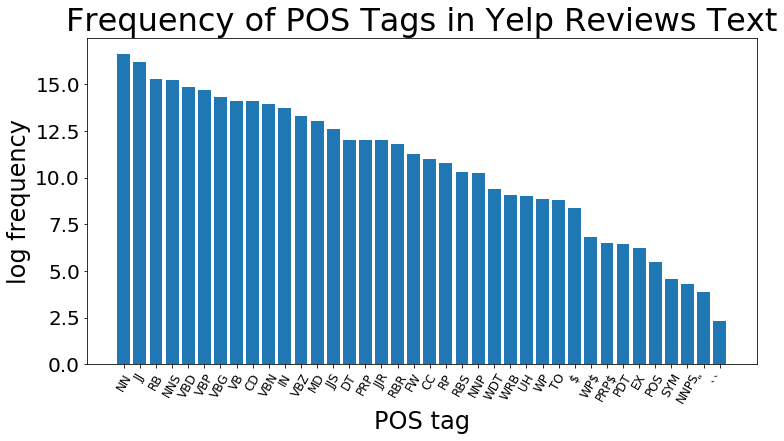

In [6]:
# extract only tags from POS-tagged word list,
# and create a (log) frequency distribution of the tags
justtags = [pr[1] for pr in tagged]
tagfreqs = [(tag,log(float(freq))) for tag, freq in nltk.FreqDist(justtags).most_common()]

# populate a data frame with the tag frequency data, set the aesthetics of a bar plot, and display the bar plot
thedata = pandas.DataFrame(tagfreqs, columns = ['tag', 'freq'])
pos = np.arange(len(tagfreqs))
fig = plt.figure(figsize=(12,6))
plt.bar(pos, thedata['freq'])
plt.title('Frequency of POS Tags in Yelp Reviews Text')
plt.xlabel('POS tag')
plt.ylabel('log frequency')
plt.xticks(pos, thedata['tag'], rotation=60, fontsize=12)

plt.show();
    
    

<b>Step 4c</b>: Print the top 20 adjectives in the data.<br>
Here I used strategies from earlier (word frequency, tag frequency) to collect all the adjectivese from the POS-tagged list, and then compute the top twenty.<br><br>
For this step, I looked up the UPenn tagset (14).

In [7]:
# extract only adjectives from tagged word list
adjectives = [ pr[0] for pr in tagged if re.match("JJ",pr[1])]
# create frequency distribution for adjectives and save the top 20 list for later use
top20adjfreqs = nltk.FreqDist(adjectives).most_common(20)
print("most frequent 20 adjectives: ", top20adjfreqs)


most frequent 20 adjectives:  [('great', 590757), ('good', 528640), ('best', 180186), ('nice', 168699), ('delicious', 125313), ('ive', 124089), ('little', 113953), ('new', 108678), ('friendly', 105121), ('awesome', 88928), ('first', 86886), ('fresh', 85162), ('happy', 82863), ('bad', 82524), ('sure', 77153), ('much', 76266), ('excellent', 70453), ('last', 70209), ('many', 67982), ('next', 67587)]


<b>Step 4d</b>: Print the top 20 proper nouns in the data. *Note that both NNP (singular) and NNPS (plural) are tags used for proper nouns.*<br><br>
Here I used strategies from earlier to collect all the proper nouns from the POS-tagged list, and then compute the top twenty. This didn't work as well as I might have liked, though I did try it with both original case preserved and all words lowercase. As I mentioned earlier, I decided to err on the side of underidentification rather than over. Otherwise we end up with the first words of sentences turning up as proper nouns, I imagine solely because they are capitalized.

In [8]:
# extract only adjectives from tagged word list
pnouns = [ pr[0] for pr in tagged if re.match("NNPS?",pr[1])]
# create frequency distribution and compute the top 20
print("most frequent 20 proper nouns: ", nltk.FreqDist(pnouns).most_common(20))

   

most frequent 20 proper nouns:  [('à', 3429), ('était', 715), ('kitchen', 710), ('ça', 703), ('zucchini', 626), ('yummy', 621), ('know', 580), ('xs', 577), ('yum', 526), ('kinda', 488), ('x', 457), ('été', 435), ('la', 421), ('xmas', 324), ('kick', 284), ('uber', 267), ('barber', 240), ('être', 239), ('madison', 225), ('october', 200)]


<b>Step 5a</b>: Train a word2vect or FastText model word embeddings model. Make some reasonable choices about window size, threshold of words to include, and other important model parameters. Explain these choices in the Jupyter Notebook you will submit.<br>
I tried building the model both with individual words and with sentences (17), but of course the word embeddings are much better (that is, the similarity results in the next step are much more intuitive) when trained on sentences. Based on my reading about model parameters (15,16) I decided to exclude words with frequency lower than 20 to do away with misspellings, names, atypical slang, etc. I decided to make my window size 3 because if a reviewer commented on several issues in the same sentence, I didn't want the multiple topics to bleed into each other too much. As for vector size, I chose a relatively low value (100) because it produced quite good results and I didn't see the need to increase the computational work done by the model if it was already achieving reasonable conclusions.

In [9]:
# create a Word2Vec model with parameters justified above
w2vmodel = Word2Vec(min_count=20,window=3,size=100,workers=3)

t = time()
# build vocabulary based on tokenized sentences
w2vmodel.build_vocab(sentsnostops)
print('Time to build vocab of size ', len(w2vmodel.wv.vocab), ': {} mins'.format(round((time() - t) / 60, 2)))

t = time()
# train model based on tokenized sentences
w2vmodel.train(sentsnostops, total_examples=len(sentsnostops), epochs=10, report_delay=1) 
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))


Time to build vocab of size  35896 : 0.63 mins
Time to train the model: 7.32 mins


<b>Step 5b</b>: For the top 20 adjectives in the text data file you used for training your embedding model, query the embedding model for the 3 most similar words.<br>
I used the sample code from the assignment description, with an update to avoid a deprecated function.

In [10]:
# extract just the adjectives from the earlier top 20 frequency list
top20adj = [pr[0] for pr in top20adjfreqs]
# for each of the top 20 adjectives, find which words in the model are most similar
for adj in top20adj:
    print(adj, " is similar to : ", w2vmodel.wv.most_similar(adj, topn=3))
    

great  is similar to :  [('awesome', 0.9047826528549194), ('fantastic', 0.8693714141845703), ('excellent', 0.8566364049911499)]
good  is similar to :  [('decent', 0.835787296295166), ('great', 0.7782758474349976), ('awesome', 0.7143121957778931)]
best  is similar to :  [('greatest', 0.7959448099136353), ('worst', 0.7736527323722839), ('tastiest', 0.7459214329719543)]
nice  is similar to :  [('cool', 0.7575682401657104), ('lovely', 0.7170439958572388), ('cute', 0.6779528856277466)]
delicious  is similar to :  [('delish', 0.9277181029319763), ('yummy', 0.8999419212341309), ('tasty', 0.8943932056427002)]
ive  is similar to :  [('weve', 0.9159360527992249), ('havent', 0.6323744058609009), ('havnt', 0.574849009513855)]
little  is similar to :  [('bit', 0.8567115068435669), ('lil', 0.8368251323699951), ('tad', 0.8307899236679077)]
new  is similar to :  [('newest', 0.6286790370941162), ('current', 0.6000679135322571), ('yorknew', 0.5470657348632812)]
friendly  is similar to :  [('polite', 0.7

<b>References</b><br>

(1) Tsutsui, Satoshi. yelp_dataset_challenge_academic_dataset.tar. Retrieved September 17, 2019, from https://drive.google.com/drive/u/0/folders/0Bx7LW_LCYVXxNkUzZ01HVHRiZ3M

(2) Tsutsui, Satoshi. exmple_to_open.html. Retrieved September 17, 2019, from https://drive.google.com/drive/u/0/folders/0B046sNk0DhCDT1laRjhwb3FQSTQ

(3) How to extract the substring between two markers?. Retrieved September 24, 2019, from https://stackoverflow.com/q/4666973

(4) UnicodeDecodeError in Python when reading a file, how to ignore the error and jump to the next line?. Retrieved September 24, 2019, from https://stackoverflow.com/q/24616678

(5) Reading utf-8 escape sequences from a file. Retrieved September 24, 2019, from https://stackoverflow.com/q/23933784

(6) Megret, P. (2018, October 20). Gensim Word2Vec Tutorial. Retrieved from https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

(7) Best way to strip punctuation from a string. Retrieved September 24, 2019, from https://stackoverflow.com/q/265960

(8) Removing stop words with NLTK in Python. Retrieved September 24, 2019, from https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

(9) Bird, S., Klein, E., and Loper, E. (n.d.). Categorizing and Tagging Words. *Natural Language Processing with Python*. Retrieved September 17, 2019, from https://www.nltk.org/book/ch05.html

(10) Matplotlib Histogram. Retrieved September 24, 2019, from https://pythonspot.com/matplotlib-histogram/

(11) How do you change the size of figures drawn with matplotlib?. Retrieved September 24, 2019, from https://stackoverflow.com/q/332289

(12) how to change xticks font size in a matplotlib plot. Retrieved September 24, 2019, from https://stackoverflow.com/q/45710545

(13) Siddiqi, A. (2017, November 15). Data Visualization in Python — Bar Graph in Matplotlib. Retrieved from https://medium.com/python-pandemonium/data-visualization-in-python-bar-graph-in-matplotlib-f1738602e9c4

(14) Alphabetical list of part-of-speech tags used in the Penn Treebank Project. Retrieved September 17, 2019, from https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

(15) models.word2vec – Word2vec embeddings. Retrieved September 24, 2019, from https://radimrehurek.com/gensim/models/word2vec.html

(16) Li, Z. (2019, May 30). A Beginner’s Guide to Word Embedding with Gensim Word2Vec Model. Retrieved from https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92

(17) Ganesan, K. (2018, February 19). How to get started with Word2Vec — and then how to make it work. Retrieved from https://www.freecodecamp.org/news/how-to-get-started-with-word2vec-and-then-how-to-make-it-work-d0a2fca9dad3/